In [1]:
import RPi.GPIO as GPIO
import gpiozero
import time
import numpy as np
import warnings
from matplotlib import pyplot as plt
from matplotlib.patches import Arrow
from IPython import display
import cv2
import threading

%matplotlib inline
plt.ion()  # Turn on interactive mode



In [2]:
###################################################### Defining our Constants ######################################################
# Encoder pins
# ML = motor left, MR = motor right
GPIO.cleanup()
GPIO.setmode(GPIO.BCM)
GPIO.setwarnings(False)

ML_ENC_A = 15 # yellow encoder c 23
ML_ENC_B = 14 # white encoder c 24

MR_ENC_A = 24 # yellow encoder c
MR_ENC_B = 23 # white encoder c

# The number of encoder steps per revolution. This was calculated according to the math that Lacie had in Notion.
MAX_ENC_STEPS = 900

# Motor Pins
ML_IN1 = 17 # IN1 
ML_IN2 = 27 # IN2
ML_ENA = 11 # Used for PWM

MR_IN3 = 22 # IN3
MR_IN4 = 10 # IN4
MR_ENB = 9 # Used for PWM

# Physical dimensions
WHEEL_RADIUS = 0.027 # meters
WHEEL_SEP = 0.229 # meters

# wheel separation measurement (ASCII art)
"""
    <------- l ------->
    |                 |
 ___|___           ___|___
|       |         |       |
|   O   |         |   O   |
|_______|         |_______|
    ^                 ^
    |                 |
  Left wheel       Right wheel
  center            center
"""


/tmp/ipykernel_1633/899567074.py:4: RuntimeWarning: No channels have been set up yet - nothing to clean up!  Try cleaning up at the end of your program instead!
  GPIO.cleanup()


'\n    <------- l ------->\n    |                 |\n ___|___           ___|___\n|       |         |       |\n|   O   |         |   O   |\n|_______|         |_______|\n    ^                 ^\n    |                 |\n  Left wheel       Right wheel\n  center            center\n'

In [3]:

###################################################### Class Definitions ######################################################

# Used to implement smoothing dt. Lower alpha means less smoothing, faster response to changes
class ExponentialMovingAverage:
    def __init__(self, alpha):
        self.alpha = alpha
        self.value = None

    def update(self, new_value):
        if self.value is None:
            self.value = new_value
        else:
            self.value = (1 - self.alpha) * new_value + self.alpha * self.value
        return self.value
    

# Used to implement velocity smoothing. Lower tau means less smoothing, faster response to changes.
class LowPassFilter:
    def __init__(self, tau):
        self.tau = tau
        self.previous_value = None
        self._last_smoothed_value = None

    def update(self, new_value, dt):
        if self.previous_value is None:
            self.previous_value = new_value
            self._last_smoothed_value = new_value
        else:
            alpha = dt / (self.tau + dt)
            self._last_smoothed_value = alpha * new_value + (1 - alpha) * self.previous_value
            self.previous_value = self._last_smoothed_value
        return self._last_smoothed_value

    @property
    def value(self):
        if self._last_smoothed_value is None:
            return 0
        return self._last_smoothed_value
    

class DiffDriveRobot:
    def __init__(
            self, 
            dt=0.05, 
            real_time=False,
            tau = 0.1,
            wheel_radius=WHEEL_RADIUS, 
            wheel_sep=WHEEL_SEP,
            max_enc_steps=MAX_ENC_STEPS,
            ml_pwm=ML_ENA,
            mr_pwm=MR_ENB,
            ml_in1=ML_IN1,
            ml_in2=ML_IN2,
            mr_in3=MR_IN3,
            mr_in4=MR_IN4,
            ml_encA=ML_ENC_A,
            ml_encB=ML_ENC_B,
            mr_encA=MR_ENC_A,
            mr_encB=MR_ENC_B
    ):
        self.x = 0.0  # x-position, meters
        self.y = 0.0  # y-position, meters
        self.th = 0.0  # orientation, angle in radians
        
        self.wl = 0.0  # rotational velocity left wheel, rad/s
        self.wr = 0.0  # rotational velocity right wheel, rad/s
        
#         self.wl_prev = 0
#         self.wr_prev = 0
        
        self.wl_smoothed = LowPassFilter(tau)
        self.wr_smoothed = LowPassFilter(tau)
                
        self.dt = dt # time delta in seconds. The control loop runs every dt. Faster means the control loop runs more often. We can increase this to reduce CPU load on our robot.
        self.r = wheel_radius # wheel radius in meters.
        self.l = wheel_sep # wheel separation in meters
        self.max_enc_steps = max_enc_steps # steps in the encoder per revolution
        
        self.real_time = real_time # if True, the wheel velocity measurements consider the actual time elapsed between measurements. If False, it uses the predefined dt value.
        self.last_update = None # last time the control loop ran

        # Pin numbers
        self.motor_L_in1 = ml_in1 # Input 1 (motor left)
        self.motor_L_in2 = ml_in2 # Input 2 (motor left)
        self.motor_R_in3 = mr_in3 # Input 3 (motor right)
        self.motor_R_in4 = mr_in4 # Input 4 (motor right)
        GPIO.setup(self.motor_L_in1, GPIO.OUT)
        GPIO.setup(self.motor_L_in2, GPIO.OUT)
        GPIO.setup(self.motor_R_in3, GPIO.OUT)
        GPIO.setup(self.motor_R_in4, GPIO.OUT)      
        
        # Initialize encoders
        self.ML_ENC = gpiozero.RotaryEncoder(a=ml_encA, b=ml_encB, max_steps=max_enc_steps, wrap=True)
        self.MR_ENC = gpiozero.RotaryEncoder(a=mr_encA, b=mr_encB, max_steps=max_enc_steps, wrap=True)
        self.ml_enc_steps = 0 # left motor encoder value (AKA shaft angle) in steps. Note, this is NOT in radians. It counts from 0 -> MAX_ENC_STEPS -> -MAX_ENC_STEPS (wraps around to -ve value)
        self.mr_enc_steps = 0 # right motor encoder value (AKA shaft angle) in steps. 

        # Initialize motor control pins
        GPIO.setup(ml_pwm, GPIO.OUT)
        GPIO.setup(mr_pwm, GPIO.OUT)
        self.motor_L_pwm = GPIO.PWM(ml_pwm, 1000)  # 1000 Hz frequency. This works well for our motor. Remember that motor speed is controlled by varying the duty cycle of our PWM frequency, and not the frequency itself. 
        self.motor_R_pwm = GPIO.PWM(mr_pwm, 1000)
        self.motor_L_pwm.start(0)
        self.motor_R_pwm.start(0)
    '''
    This method calculates the change in encoder steps between the current and previous time step.
    The logic might seem complicated but this is to deal with the wraparound in value (from 0 -> MAX_ENC_STEPS -> -MAX_ENC_STEPS) that the encoder values have.
    e.g. for the first rotation, the encoder goes from 0 to 3600, then for every rotation thereafter, it goes from -3600 to 3600, then wraps around again.
    '''
    @property
    def pose(self):
        return (self.x, self.y, self.th)
    
    def get_encoder_delta(self, curr_value, prev_value):
        raw_delta = curr_value - prev_value
        delta = raw_delta
        wraparound_thresh = np.ceil((2*self.max_enc_steps + 1) / 2)
        
        if raw_delta > wraparound_thresh:
            delta = raw_delta - (2*self.max_enc_steps+1)
        elif raw_delta < -wraparound_thresh:
            delta = raw_delta + (2*self.max_enc_steps+1)
        
        return delta
            
    def get_dt(self):
        #TODO: Implement smoothing for dt - potentially moving average
        if not self.real_time:
            return self.dt
        
        now = time.time()
        # print(f"Last update: {self.last_update}")
        if self.last_update is None:
            self.last_update = now
            return self.dt
        
        dt = now - self.last_update
        self.last_update = now # this needs to be in between the above and below lines. Don't move it 
        return dt
    
    # Wheel velocities in radians/sec
    '''
    This method reads the encoder values and calculates the wheel velocities in rad/s.
    It uses the get_encoder_delta method to calculate the change in encoder steps between the current and previous time step.
    It then converts this change in steps to radians, and then to radians per second.
    '''
    def read_wheel_velocities(self, dt):
        
        ml_enc_now, mr_enc_now = self.ML_ENC.steps, self.MR_ENC.steps

        # Calculate change in steps, accounting for wrap-around
        ml_enc_delta = self.get_encoder_delta(ml_enc_now, self.ml_enc_steps)
        mr_enc_delta = self.get_encoder_delta(mr_enc_now, self.mr_enc_steps)

        # Convert step change to radians
        ml_delta_rad = ml_enc_delta / self.max_enc_steps * 2 * np.pi 
        mr_delta_rad = mr_enc_delta / self.max_enc_steps * 2 * np.pi

        # Calculate velocities
#         self.wl_prev = self.wl
#         self.wr_prev = self.wr
        
        self.wl = ml_delta_rad / dt # rad/s
        self.wr = mr_delta_rad / dt # rad/s
        
        # Calculate smoothed velocities
#         self.wl_smoothed = self.tau/(self.tau+dt) * self.wl_prev + dt/(self.tau+dt) * self.wl
#         self.wr_smoothed = self.tau/(self.tau+dt) * self.wr_prev + dt/(self.tau+dt) * self.wr
        
        self.wl_smoothed.update(self.wl, dt)
        self.wr_smoothed.update(self.wr, dt)
        
        # Update previous steps
        self.ml_enc_steps = ml_enc_now
        self.mr_enc_steps = mr_enc_now

        return self.wl, self.wr
  
    '''
    This method sets the motor speed based on the duty cycle provided. 
    It also sets the direction of the motor based on the sign of the duty cycle.
    The duty cycle is the percentage of time the motor is on, and it MUST be a value between -100 and 100.
    '''
    def set_motor_speed(self, left_duty_cycle, right_duty_cycle):      
        # Set direction
        GPIO.output(self.motor_L_in1, GPIO.HIGH if left_duty_cycle >= 0 else GPIO.LOW)
        GPIO.output(self.motor_L_in2, GPIO.LOW if left_duty_cycle >= 0 else GPIO.HIGH)
        GPIO.output(self.motor_R_in3, GPIO.HIGH if right_duty_cycle >= 0 else GPIO.LOW)
        GPIO.output(self.motor_R_in4, GPIO.LOW if right_duty_cycle >= 0 else GPIO.HIGH)
            
        # Set speed
        self.motor_L_pwm.ChangeDutyCycle(abs(left_duty_cycle))
        self.motor_R_pwm.ChangeDutyCycle(abs(right_duty_cycle))


    '''
    This method calculates the linear and angular velocity of the robot based on the wheel velocities.
    It uses the formulae for differential drive robots to calculate the linear and angular velocity.
    This is pretty much identical to Michael's code in the ECE4191 repo.
    '''
    def base_velocity(self, wl, wr):
        v = (wl * self.r + wr * self.r) / 2.0 # linear velocity, m/s, +ve is forward
        w = -(wl * self.r - wr * self.r) / self.l # angular velocity, rad/s, +ve is CCW. Note that the negative sign
        # is due to the way the motors are oriented, and so we need it to 'correct' our w calculation
        # so that +ve w is CCW, adhering to convention.
        return v, w
    
    
    """
    This method updates the robot's pose (x, y, theta) based on the wheel velocities.
    It uses the base_velocity method to calculate the linear and angular velocity of the robot.
    It then uses these velocities to update the robot's pose (x, y, theta) based on the kinematic equations.
    """
    def pose_update(self, duty_cycle_ml, duty_cycle_mr):
        # TODO: remove the call to get_dt here, relocate it to the read_wheel_velocities method, and remove the need for it in the pose_update method (below) by having read_wheel_velocities return dt, or the distance travelled (dt*v) directly.
        dt = self.get_dt()
        
        self.set_motor_speed(duty_cycle_ml, duty_cycle_mr)

        wl, wr = self.read_wheel_velocities(dt) # get wheel velocities in rad/s
        v, w = self.base_velocity(wl, wr)
        
        self.x = self.x + dt * v * np.cos(self.th)
        self.y = self.y + dt * v * np.sin(self.th)
        self.th = self.th + w * dt
        
        return self.x, self.y, self.th
    
    
class RobotController:
    def __init__(self, Kp=9, Ki=9, dt=0.05, wheel_radius = 0.028, wheel_sep = 0.222, integral_windup=True, real_time=False):
        self.Kp = Kp            # Proportional gain
        self.Ki = Ki            # Integral gain
        self.dt = dt            # Time step
        
        self.r = wheel_radius
        self.l = wheel_sep
        
        self.min_output = -100  # Minimum duty cycle (-100%)
        self.max_output = 100  # Maximum duty cycle (100%)
        
        self.ml_integral = 0       # Integral term, motor left
        self.mr_integral = 0       # Integral term, motor right
        self.ml_last_update, self.mr_last_update = None, None  # Last update time

        self.anti_integral_windup = integral_windup  # Anti-windup flag
        self.real_time = real_time

    """
    Gets the time of the last measurement/update for the motor ml or mr
    """
    def get_dt(self, motor=None):
        #TODO: Implement smoothing for dt - potentially moving average
        if motor not in ['ml', 'mr']:
            raise ValueError("Motor must be 'ml' or 'mr'.")

        if not self.real_time:
            return self.dt
        
        last_update = f"{motor}_last_update"
        now = time.time()
#         print(f"Last update: {getattr(self, last_update)}")
        if getattr(self, last_update) is None:
            setattr(self, last_update, now)
            return self.dt
        
        dt = now - getattr(self, last_update)
        setattr(self, last_update, now)
        return dt


    def compute(self, w_target, w_actual, motor=None):
        # motor should be either "ml" or "mr" for left or right motor
        if motor not in ['ml', 'mr']:
            raise ValueError("Motor must be 'ml' or 'mr'.")
        integral_attr = f"{motor}_integral"
        last_update = f"{motor}_last_update"
        
        dt = self.get_dt(motor)
        
        error = w_target - w_actual # Calculate the error
        P_out = self.Kp * error # Proportional term
        I_out = self.Ki * getattr(self,integral_attr) # Integral term
        raw_output = P_out + I_out

        if self.anti_integral_windup:
            # Anti-windup - only integrate if output is not saturated
            if self.min_output < raw_output < self.max_output:
                setattr(self, integral_attr, getattr(self, integral_attr) + error * dt)
                # equiv. to self.ml_integral += error * self.dt or self.mr_integral += error * self.dt
        else:
            setattr(self, integral_attr, getattr(self, integral_attr) + error * dt)
                        
            
        return np.clip(raw_output, self.min_output, self.max_output) # Clamp the output to the min/max duty cycle limits
        
    
    def diff_drive_control(self, v_desired, w_desired, wl_actual, wr_actual):
        # v_desired: m/s
        # w_desired (rotation), wl_actual, w_actual (rotation): rad/s
        
        # Calculate desired wheel angular velocities
        wl_desired = (v_desired + self.l*w_desired/2)/self.r
        wr_desired = (v_desired - self.l*w_desired/2)/self.r
        
#         print(f"wl_des (rad/s): {wl_desired:.2f}, wr_des: {wr_desired:.2f}\nwl_des (rps): {wl_desired/(2*np.pi):.2f}, wr_des: {wr_desired/(2*np.pi):.2f}")

        # Compute duty cycles for left and right wheels
        duty_cycle_l = self.compute(wl_desired, wl_actual, 'ml')
        duty_cycle_r = self.compute(wr_desired, wr_actual, 'mr')
        return duty_cycle_l, duty_cycle_r, wl_desired, wr_desired

    

In [4]:


class TentaclePlanner:
    def __init__(
        self,
        obstacles  = [],
        dt = 0.1,
        steps = 5,
        alpha = 1,
        beta = 0.1,
        max_linear_velocity = 0.23, # 0.23 m/s is at about 75% duty cycle.
        max_angular_velocity = 2.1, # 2.1 rad/s is about 78% duty cycle
        max_linear_tolerance = 0.1, # meters
        max_angular_tolerance = 0.15, # radians, 0.15 radians is about 8.6 degrees
        max_acceleration = 0.2,
        current_linear_velocity = 0.0,
        current_angular_velocity = 0.0
    ):
        self.dt = dt
        self.steps = steps
        self.alpha = alpha
        self.beta = beta
        self.obstacles = np.array(obstacles)
        self.max_linear_velocity = max_linear_velocity
        self.max_angular_velocity = max_angular_velocity
        self.max_linear_tolerance = max_linear_tolerance
        self.max_angular_tolerance = max_angular_tolerance  # New attribute
        self.max_acceleration = max_acceleration
        self.current_linear_velocity = current_linear_velocity
        self.current_angular_velocity = current_angular_velocity
        
        self.tentacles = self._generate_tentacles()

    def _generate_tentacles(self):
        linear_velocities = np.linspace(-self.max_linear_velocity, self.max_linear_velocity, 5)
        angular_velocities = np.linspace(-self.max_angular_velocity, self.max_angular_velocity, 5)
        tentacles = [(v, w) for v in linear_velocities for w in angular_velocities]
        tentacles.append((0.0, 0.0))  # Add stop option
        return tentacles

    def is_goal_reached(self, goal_x, goal_y, goal_th, x, y, th):
        distance_to_goal = np.hypot(goal_x - x, goal_y - y)
        angular_error = np.arctan2(np.sin(goal_th - th), np.cos(goal_th - th))
        return distance_to_goal <= self.max_linear_tolerance and abs(angular_error) <= self.max_angular_tolerance

    def trapezoidal_profile(self, distance, current_velocity, max_velocity):
        acceleration_distance = (max_velocity ** 2) / (2 * self.max_acceleration)
        if distance <= 2 * acceleration_distance:
            t_accel = np.sqrt(distance / self.max_acceleration)
            velocity = min(current_velocity + self.max_acceleration * t_accel, max_velocity)
        else:
            velocity = max_velocity
        return velocity

    def adjust_velocity(self, current_velocity, target_velocity):
        delta_v = target_velocity - current_velocity
        if abs(delta_v) > self.max_acceleration:
            return current_velocity + np.sign(delta_v) * self.max_acceleration
        return target_velocity

    def _roll_out(self, v, w, goal_x, goal_y, goal_th, x, y, th):
        for _ in range(self.steps):
            x += self.dt * v * np.cos(th)
            y += self.dt * v * np.sin(th)
            th += w * self.dt

            if self._check_collision(x, y):
                return np.inf

        e_th = np.arctan2(np.sin(goal_th - th), np.cos(goal_th - th))
        cost = self.alpha * ((goal_x - x) ** 2 + (goal_y - y) ** 2) + self.beta * (e_th ** 2)
        return cost

    def _check_collision(self, x, y):
        if len(self.obstacles) == 0:
            return False
        min_dist = np.min(np.hypot(x - self.obstacles[:, 0], y - self.obstacles[:, 1]))
        return min_dist < 0.1

    def plan(self, goal_x, goal_y, goal_th, x, y, th, use_straight_line=False):
        if self.is_goal_reached(goal_x, goal_y, goal_th, x, y, th):
            print("Goal is within tolerance, stopping planner function")
            return (0.0, 0.0)

        if use_straight_line:
            return self._plan_straight_line(goal_x, goal_y, goal_th, x, y, th)

        costs = [self._roll_out(v, w, goal_x, goal_y, goal_th, x, y, th) for v, w in self.tentacles]
        best_idx = np.argmin(costs)
        return self.tentacles[best_idx]

    def _plan_straight_line(self, goal_x, goal_y, goal_th, x, y, th):
        if self.is_goal_reached(goal_x, goal_y, goal_th, x, y, th):
            print("Goal is within tolerance, stopping planner function")
            return (0.0, 0.0)

        dx, dy = goal_x - x, goal_y - y
        distance = np.hypot(dx, dy)

        desired_th = np.arctan2(dy, dx)
        e_th = np.arctan2(np.sin(desired_th - th), np.cos(desired_th - th))

        v = self.trapezoidal_profile(distance, self.current_linear_velocity, self.max_linear_velocity)
        w = np.clip(e_th / self.dt, -self.max_angular_velocity, self.max_angular_velocity)

        v_adjusted = self.adjust_velocity(self.current_linear_velocity, v)
        w_adjusted = self.adjust_velocity(self.current_angular_velocity, w)

        self.current_linear_velocity = v_adjusted
        self.current_angular_velocity = w_adjusted

        return v_adjusted, w_adjusted

    def get_control_inputs(self, goal_x, goal_y, goal_th, x, y, th, use_straight_line=False):
        v, w = self.plan(goal_x, goal_y, goal_th, x, y, th, use_straight_line)
        return {
            'linear_velocity': v,
            'angular_velocity': w,
            'current_x': x,
            'current_y': y,
            'current_theta': th,
            'goal_x': goal_x,
            'goal_y': goal_y,
            'goal_theta': goal_th
        }

    def visualize_tentacles(self, x, y, th, extrapolation_steps=100):
        plt.figure(figsize=(12, 12))
        plt.scatter(x, y, color='green', s=100, label='Start')

        colors = plt.cm.rainbow(np.linspace(0, 1, len(self.tentacles)))

        for (v, w), color in zip(self.tentacles, colors):
            x_traj, y_traj = [x], [y]
            th_traj = th
            for _ in range(self.steps):
                x_new = x_traj[-1] + self.dt * v * np.cos(th_traj) * extrapolation_steps
                y_new = y_traj[-1] + self.dt * v * np.sin(th_traj) * extrapolation_steps
                x_traj.append(x_new)
                y_traj.append(y_new)
                th_traj += w * self.dt

                if _ == self.steps // 2:
                    dx, dy = x_new - x_traj[-2], y_new - y_traj[-2]
                    arrow = Arrow(x_traj[-2], y_traj[-2], dx, dy, width=0.2, color=color)
                    plt.gca().add_patch(arrow)

            plt.plot(x_traj, y_traj, '-', color=color, linewidth=2, label=f'v={v:.2f}, w={w:.2f}')

        if len(self.obstacles) > 0:
            plt.scatter(self.obstacles[:, 0], self.obstacles[:, 1], color='red', s=50, label='Obstacles')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title('Tentacle Visualization')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

    def visualize_plan(self, goal_x, goal_y, goal_th, x, y, th, use_straight_line=False, extrapolation_steps=100):
        v, w = self.plan(goal_x, goal_y, goal_th, x, y, th, use_straight_line)

        plt.figure(figsize=(10, 10))
        plt.scatter(x, y, color='green', s=100, label='Start')
        plt.scatter(goal_x, goal_y, color='blue', s=100, label='Goal')

        x_traj, y_traj = [x], [y]
        th_traj = th
        for _ in range(self.steps):
            x_traj.append(x_traj[-1] + self.dt * v * np.cos(th_traj) * extrapolation_steps)
            y_traj.append(y_traj[-1] + self.dt * v * np.sin(th_traj) * extrapolation_steps)
            th_traj += w * self.dt
        plt.plot(x_traj, y_traj, 'g-', linewidth=2, label='Chosen Path')

        if len(self.obstacles) > 0:
            plt.scatter(self.obstacles[:, 0], self.obstacles[:, 1], color='red', s=50, label='Obstacles')
        plt.legend()
        plt.title(f'Planned Path (v={v:.2f}, w={w:.2f})')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)
        plt.axis('equal')
        plt.show()

# # Create an instance of the planner
# obstacles = np.array([[1, 1], [2, 2], [3, 1]])  # Example obstacles
# planner = TentaclePlanner(obstacles, max_linear_velocity=1.0, max_angular_velocity=0.5)

# # Get control inputs for tentacle-based planning
# inputs = planner.get_control_inputs(goal_x=5, goal_y=5, goal_th=0, x=0, y=0, th=0)
# print("Tentacle-based planning:", inputs)

# # Get control inputs for straight-line planning
# inputs_straight = planner.get_control_inputs(goal_x=5, goal_y=5, goal_th=0, x=0, y=0, th=0, use_straight_line=True)
# print("Straight-line planning:", inputs_straight)

# # Visualize the plan
# planner.visualize_plan(goal_x=5, goal_y=5, goal_th=0, x=0, y=0, th=0)
# planner.visualize_plan(goal_x=5, goal_y=5, goal_th=0, x=0, y=0, th=0, use_straight_line=True)

In [5]:



class TennisBallDetector:
    def __init__(self, lower_color=(20, 100, 100), upper_color=(40, 255, 255), min_radius=10, max_radius=50, min_area=1000, line_distance=100):
        self.camera = cv2.VideoCapture(0)  # Try changing to 2, 3, etc., if 1 doesn't work
        self.lower_color = np.array(lower_color)
        self.upper_color = np.array(upper_color)
        self.min_radius = min_radius
        self.max_radius = max_radius
        self.min_area = min_area
        self.balls = []
        self.frame_center = None
        self.last_scanned_time = None
        self.kernel = np.ones((5, 5), np.uint8)
        self.line_distance = line_distance
        self.frame = None
        
        if not self.camera.isOpened():
            print("Error: Could not open USB camera.")

    def detect(self, retry=True, max_num_retries=10, retry_interval=1):
        counter = 0
        
        while counter < max_num_retries:

            ret, self.frame = self.camera.read()
            if not ret:
                print("Error: Failed to capture image.")
                return
            self.last_scanned_time = time()
            self.frame_center = (self.frame.shape[1] // 2, self.frame.shape[0] // 2)

            hsv = cv2.cvtColor(self.frame, cv2.COLOR_BGR2HSV)
            mask = cv2.inRange(hsv, self.lower_color, self.upper_color)

            # Perform morphological operations
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, self.kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, self.kernel)

            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            self.balls = []

            for contour in contours:
                area = cv2.contourArea(contour)
                if area > self.min_area:
                    ((x, y), radius) = cv2.minEnclosingCircle(contour)
                    if self.min_radius < radius < self.max_radius:
                        self.balls.append(((int(x), int(y)), int(radius)))

            # Sort balls by size (largest first) if multiple balls are detected
            self.balls.sort(key=lambda ball: ball[1], reverse=True)
            if len(self.balls) > 0:
                return True
            else:
                counter += 1
        return False

    def get_ball_count(self):
        return len(self.balls)

    def get_ball_locations(self):
        return [ball[0] for ball in self.balls]

    def get_ball_distance_from_center(self, ball_index):
        if 0 <= ball_index < len(self.balls):
            ball_center = self.balls[ball_index][0]
            dx = ball_center[0] - self.frame_center[0]
            dy = ball_center[1] - self.frame_center[1]
            distance_pixels = np.sqrt(dx**2 + dy**2)
            angle_radians = np.arctan2(dy, dx)
            return distance_pixels, angle_radians
        else:
            return None

    def draw_balls(self, frame=None):
        if not frame:
            frame = self.frame
        for i, (center, radius) in enumerate(self.balls):
            color = (0, 255, 0) if i == 0 else (0, 255, 255)  # Green for largest, Yellow for others
            cv2.circle(frame, center, radius, color, 2)
            cv2.circle(frame, center, 5, (0, 0, 255), -1)
        return frame

    def get_last_scanned_time(self):
        return self.last_scanned_time

    def draw_vertical_lines(self, frame=None):
        if not frame:
            frame = self.frame
        height, width = frame.shape[:2]
        left_x = width // 2 - self.line_distance // 2
        right_x = width // 2 + self.line_distance // 2
        
        cv2.line(frame, (left_x, 0), (left_x, height), (255, 0, 0), 2)
        cv2.line(frame, (right_x, 0), (right_x, height), (255, 0, 0), 2)
        
        return frame

    def is_ball_between_lines(self, ball_index=0):
        if 0 <= ball_index < len(self.balls):
            ball_center, ball_radius = self.balls[ball_index]
            height, width = self.camera.get(cv2.CAP_PROP_FRAME_HEIGHT), self.camera.get(cv2.CAP_PROP_FRAME_WIDTH)
            left_x = width // 2 - self.line_distance // 2
            right_x = width // 2 + self.line_distance // 2
            
            # Check if the entire ball is between the lines
            return (left_x <= ball_center[0] - ball_radius) and (ball_center[0] + ball_radius <= right_x)
        else:
            return False

    # returns tennis ball distance from center lines. -ve means on left. +ve means on right.
    def get_ball_distance_from_lines(self, ball_index=0):
        if 0 <= ball_index < len(self.balls):
            ball_center, _ = self.balls[ball_index]
            height, width = self.camera.get(cv2.CAP_PROP_FRAME_HEIGHT), self.camera.get(cv2.CAP_PROP_FRAME_WIDTH)
            left_x = width // 2 - self.line_distance // 2
            right_x = width // 2 + self.line_distance // 2
            
            if ball_center[0] < left_x:
                return -(left_x - ball_center[0])
            elif ball_center[0] > right_x:
                return ball_center[0] - right_x
            else:
                return 0  # Ball is between the lines
        else:
            return None

    def set_line_distance(self, distance):
        self.line_distance = distance





In [6]:
# class LogData:
#     def __init__(self):
#         self.poses = []
#         self.velocities = []
#         self.desired_velocities = []
#         self.duty_cycle_commands = []
#         self.error_sums = []
#         self.errors = []
#         self.actual_dts = []

class Orchestrator:
    def __init__(self):
        self.running = True
        self.last_update = None
        self.dt = 0.1
        
        self.robot = None
        self.controller = None
        self.detector = None
        self.planner = None
        self.control_thread = None

        self.poses = []
        self.goal_positions = []
        self.velocities = []
        self.desired_velocities = []
        self.duty_cycle_commands = []
        self.error_sums = []
        self.errors = []
        self.actual_dts = []

        self.duration = 0
        self.start_time = 0

                
    def get_dt(self): 
        now = time.time()
        if self.last_update is None:
            self.last_update = now
            return self.dt
        
        dt = now - self.last_update
        self.last_update = now # this needs to be in between the above and below lines. Don't move it 
        return dt
    
    
    def control_loop(self):
        try:

            goal = (5, 5, np.pi/4)  # 45 degrees orientation
            self.goal_positions.append(goal)

            while self.running:
                
                # # Get control inputs for tentacle-based planning
                inputs = self.planner.get_control_inputs(*goal, *self.robot.pose)
#                 print("Tentacle-based planning:", inputs)

                # # Get control inputs for straight-line planning
                # inputs_straight = self.planner.get_control_inputs(*goal, *self.robot.pose, use_straight_line=True)
                # print("Straight-line planning:", inputs_straight)
                
                duty_cycle_l, duty_cycle_r, wl_desired, wr_desired = self.controller.diff_drive_control(inputs['linear_velocity'], inputs['angular_velocity'], self.robot.wl_smoothed.value, self.robot.wr_smoothed.value)
                x, y, th = self.robot.pose_update(duty_cycle_l, duty_cycle_r)
    #             display.clear_output(wait=True)
        #         print(f"v_des: {v_desired:.2f}, w_des: {w_desired:.2f}")
    #             print(f"wl_desired: {wl_desired:.2f}, wr_desired: {wr_desired:.2f}")
    #             print(f"wl_actual: {self.robot.wl:.2f}, wr_actual: {self.robot.wr:.2f}")
    #             print(f"duty cycle l: {duty_cycle_l:.2f}, r: {duty_cycle_r:.2f}")
        #         print(f"Position: ({x:.2f}, {y:.2f}), Orientation: {th:.2f}\n")

                # Add a call to Tennis Ball Detector
                # Get location of tennis ball\
                # Feed into tentacle planner
                # Feed tentacle planner output into PI controller
#                 scan_for_ball()
#                 beep_light()
#                 return_home()
                
                # We scan (rotate 135 degrees)

                # Drive forward by .8m * 2 
                
                # Scan again
                
                # 

                # Store data for plotting   
                self.poses.append([x,y,th])
#                 self.goal_positions.append(goal)
                self.duty_cycle_commands.append([duty_cycle_l,duty_cycle_r])
                self.velocities.append([self.robot.wl, self.robot.wr])
                self.desired_velocities.append([wl_desired, wr_desired])

                time.sleep(self.dt)
        except Exception:
            print("\nUnhandled Exception in Orchestrator control loop. Stopping Robot.\n")
            self.stop()
    
    # Edit this to change what the robot does
    def control_loop_example(self):
        try:

            v_target = 0.2
            w_target = 0.1
            while self.running:
                
                duty_cycle_l, duty_cycle_r, wl_desired, wr_desired = self.controller.diff_drive_control(v_target, w_target, self.robot.wl, self.robot.wr)
                x, y, th = self.robot.pose_update(duty_cycle_l, duty_cycle_r)
    #             display.clear_output(wait=True)
        #         print(f"v_des: {v_desired:.2f}, w_des: {w_desired:.2f}")
    #             print(f"wl_desired: {wl_desired:.2f}, wr_desired: {wr_desired:.2f}")
    #             print(f"wl_actual: {self.robot.wl:.2f}, wr_actual: {self.robot.wr:.2f}")
    #             print(f"duty cycle l: {duty_cycle_l:.2f}, r: {duty_cycle_r:.2f}")
        #         print(f"Position: ({x:.2f}, {y:.2f}), Orientation: {th:.2f}\n")

                # Add a call to Tennis Ball Detector
                # Get location of tennis ball\
                # Feed into tentacle planner
                # Feed tentacle planner output into PI controller


                # Store data for plotting   
                self.poses.append([x,y,th])
                self.goal_positions.append(goal)
                self.duty_cycle_commands.append([duty_cycle_l,duty_cycle_r])
                self.velocities.append([self.robot.wl, self.robot.wr])
                self.desired_velocities.append([wl_desired, wr_desired])

                time.sleep(self.dt)
        except Exception:
            print("\nUnhandled Exception in Orchestrator control loop example. Stopping Robot.\n")
            self.stop()
            
    def scan_for_ball(self):
        # Rotate on the spot. Take a picture every rotation. If I see a ball, I return.
        
        running = True
        tennis_ball_found = False
        rotation_thres = 135 * np.pi/180 # 135 degrees
        rotation_increment = 30 * np.pi/180 # 30 degrees
        rotation_angle = 0
        
        while running:
            # Take an image and try to detect tennis balls
            self.detector.detect()
            frame = detector.draw_balls()
            frame = detector.draw_vertical_lines()
            frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            print(f"Ball between lines: {is_between}")
            print(f"Distance from nearest line: {distance}")
            # Show the image
#             display.clear_output(wait=True)
            plt.imshow(frame)
            plt.show()

            # If a tennis ball or tennis balls are found
            if detector.get_ball_count() > 0:
                is_between = detector.is_ball_between_lines()
                if is_between:
                    # drive forward
                    # return out of function
                    return True
                else:
                    distance = detector.get_ball_distance_from_lines()
                    
                    if distance < 0: # if distance is -ve, turn left
                        # turn left by 10 degrees
                        pass
                    elif distance > 0: 
                        # turn right by 10 degrees
                        pass

            # If no tennis balls are found
            elif detector.get_ball_count() == 0 and rotation_increment < rotation_thres:                
                # turn 30 degrees (rotation_increment), next loop iteration scan again
                rotation_angle += rotation_increment
                
            # Reaching here means that no balls were found and we've rotated by rotation_thresh already
            else:
                return False
                            
    
    def start(self):
        if self.robot is None:
            print("Initialising robot.")
            self.robot = DiffDriveRobot(0.05, real_time=True)

        if self.controller is None:
            print("Initialising controller.")
            self.controller = RobotController(real_time=True)
            
        if self.detector is None:
            print("Initialising tennis ball detector.")
            self.detector = TennisBallDetector()
            
        if self.planner is None:
            print("Initialising tentacle planner.")
            self.planner = TentaclePlanner(max_linear_velocity=0.1, max_angular_velocity=0.5)
                    
        self.control_thread = threading.Thread(target=self.control_loop)
        self.start_time = time.time()
        self.control_thread.start()
    
    def stop(self):
        self.running = False
        self.control_thread.join()
        self.robot.set_motor_speed(0, 0)
        self.duration = time.time() - self.start_time
        print(f"Ended run. Robot ran for: {self.duration:.2f} s")

In [7]:
def update_plot(orchestrator, fig, axes):
    axes_flat = axes.flatten()  # Flatten the 2D array of axes
    for ax in axes_flat:
        ax.clear()
    
    # Plot 1: Robot path and orientation
    poses = np.array(orchestrator.poses)
    if len(poses) > 0:
        axes[0, 0].plot(np.array(poses)[:,0], np.array(poses)[:,1])
        x, y, th = poses[-1]
        axes[0, 0].plot(x, y, 'k', marker='+')
        axes[0, 0].quiver(x, y, 0.1*np.cos(th), 0.1*np.sin(th))
    axes[0, 0].set_xlabel('x-position (m)')
    axes[0, 0].set_ylabel('y-position (m)')
    axes[0, 0].set_title(f"Robot Pose Over Time. Kp: {orchestrator.controller.Kp}, Ki: {orchestrator.controller.Ki}")
    axes[0, 0].axis('equal')
    axes[0, 0].grid()

    # Plot 2: Duty cycle commands
    duty_cycle_commands = np.array(orchestrator.duty_cycle_commands)
    if len(duty_cycle_commands) > 0:
        duty_cycle_commands = np.array(duty_cycle_commands)
        axes[0, 1].plot(duty_cycle_commands[:, 0], label='Left Wheel')
        axes[0, 1].plot(duty_cycle_commands[:, 1], label='Right Wheel')
    
    axes[0, 1].set_xlabel('Time (s)')
    axes[0, 1].set_ylabel('Duty Cycle')
    axes[0, 1].set_title('Duty Cycle Commands Over Time')
    axes[0, 1].legend()
    axes[0, 1].grid()
    
    # Plot 3: Wheel velocities
    velocities = np.array(orchestrator.velocities)
    desired_velocities = np.array(orchestrator.desired_velocities)
    if len(velocities) > 0 and len(desired_velocities) > 0:
        axes[1, 0].plot(velocities[:, 0], label='Left Wheel')
        axes[1, 0].plot(velocities[:, 1], label='Right Wheel')
        axes[1, 0].plot(desired_velocities[:, 0], label='Desired Left Wheel')
        axes[1, 0].plot(desired_velocities[:, 1], label='Desired Right Wheel')
    axes[1, 0].set_xlabel('Time Step')
    axes[1, 0].set_ylabel('Wheel Velocity (rad/s)')
    axes[1, 0].set_title('Wheel Velocity vs. Time')
    axes[1, 0].legend()
    axes[1, 0].grid()
    
    # Plot 4: Goal Positions vs. actual position
#     goal_positions = np.array(orchestrator.goal_positions)
    
#     if len(poses) > 0: 
#         axes[1, 1].plot(np.array(orchestrator.poses)[:,0], np.array(orchestrator.poses)[:,1])
    
#     axes[1, 1].plot(0, 0, 'ko', markersize=10, label='Start (0, 0)')  # Add point at (0, 0)
#     if len(goal_positions) > 0:
#         goal_positions = np.vstack(([0, 0], goal_positions))
#         axes[1, 1].plot(goal_positions[:, 0], goal_positions[:, 1], 'r--', label='Goal Path')
#         axes[1, 1].set_xlabel('x-position (m)')
#     axes[1, 1].set_ylabel('y-position (m)')
#     axes[1, 1].set_title(f"Goal path vs. Actual Path")
#     axes[1, 1].axis('equal')
#     axes[1, 1].legend()
#     axes[1, 1].grid()
    goal_positions = np.array(orchestrator.goal_positions)
    poses = np.array(orchestrator.poses)

    # Add (0, 0) to both goal_positions and poses
    goal_positions = np.vstack(((0, 0, 0), goal_positions))
    poses = np.vstack(([0, 0, 0], poses))

    axes[1, 1].plot(0, 0, 'ko', markersize=10, label='Start (0, 0)')  # Add point at (0, 0)

    if len(poses) > 0: 
        axes[1, 1].plot(poses[:, 0], poses[:, 1], 'b-', label='Actual Path')
        axes[1, 1].plot(poses[:, 0], poses[:, 1], 'b.')  # Add dots for each position

    if len(goal_positions) > 0:
        axes[1, 1].plot(goal_positions[:, 0], goal_positions[:, 1], 'r--', label='Goal Path')
        axes[1, 1].plot(goal_positions[:, 0], goal_positions[:, 1], 'r.')  # Add dots for each goal position

    axes[1, 1].set_xlabel('x-position (m)')
    axes[1, 1].set_ylabel('y-position (m)')
    axes[1, 1].set_title("Goal Path vs. Actual Path")
    axes[1, 1].axis('equal')
    axes[1, 1].grid(True)
    axes[1, 1].legend()
    
    
    
    fig.tight_layout()
    display.clear_output(wait=True)
    display.display(fig)

In [8]:
orchestrator = Orchestrator()


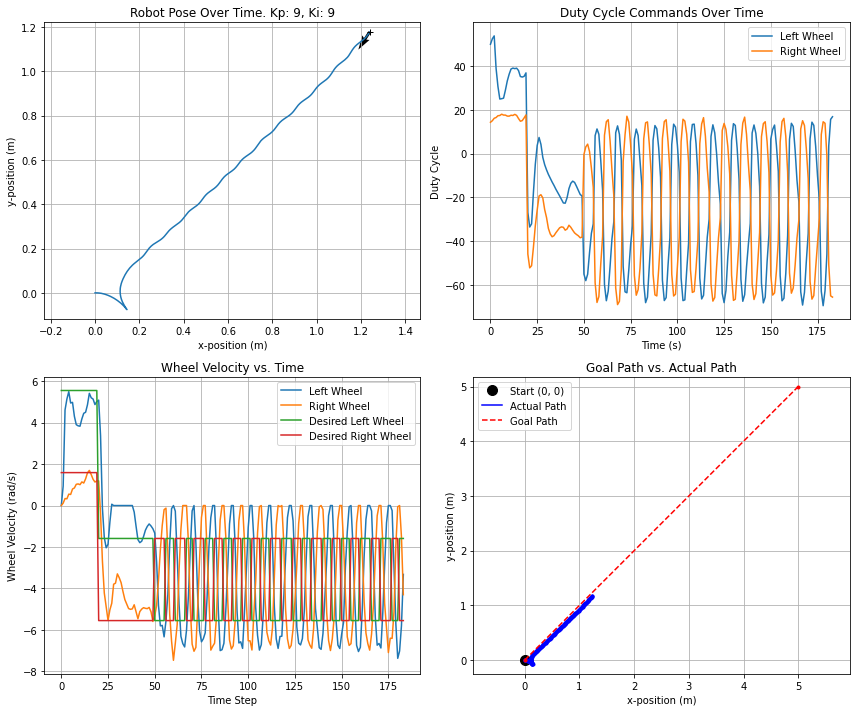

1724741509.1517107
Simulation ended.


In [9]:
orchestrator.start()


# Set up the plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Main loop for updating the plot
try:
    while True:
        pass
#         update_plot(orchestrator, fig, axes)
#         time.sleep(3)  # Update plot every 3 seconds
except KeyboardInterrupt:
    print("Stopping the simulation...")
finally:
    orchestrator.stop()
    update_plot(orchestrator, fig, axes)
    plt.close(fig)

print("Simulation ended.")

In [10]:
robot.set_motor_speed(0, 0)

NameError: name 'robot' is not defined

In [ ]:

GPIO.setwarnings(False)
robot = DiffDriveRobot(0.05, real_time=True)

In [ ]:

"""
# Control loop example. If you've already run the notebook, you MAY need to do Kernel -> Restart & Run All or Restart.
"""



# Example: Move forward at 0.5 m/s with no rotation
v_desired = 0
w_desired = 2.1 #.4*np.pi # rad/s

# Controller Parameters
Kp = 9
Ki = 9

# Initialising
controller = RobotController(Kp, Ki, real_time=True)
robot.x = 0
robot.y = 0
robot.th = 0
robot.wl = 0
robot.wr = 0

poses = []
velocities = []
desired_velocities = []
duty_cycle_commands = []
error_sums = []
errors = []
actual_dts = []


start_time, last_time = time.time(), time.time()

try:
    while True: 
        current_time = time.time()
        actual_dt = current_time - last_time
        
        duty_cycle_l, duty_cycle_r, wl_desired, wr_desired = controller.diff_drive_control(v_desired, w_desired, robot.wl_smoothed.value, robot.wr_smoothed.value)
        x, y, th = robot.pose_update(duty_cycle_l, duty_cycle_r)
        display.clear_output(wait=True)
#         print(f"v_des: {v_desired:.2f}, w_des: {w_desired:.2f}")
        print(f"wl_desired: {wl_desired:.2f}, wr_desired: {wr_desired:.2f}")
        print(f"wl_actual: {robot.wl:.2f}, wr_actual: {robot.wr:.2f}")
        print(f"duty cycle l: {duty_cycle_l:.2f}, r: {duty_cycle_r:.2f}")
#         print(f"Position: ({x:.2f}, {y:.2f}), Orientation: {th:.2f}\n")

        
        # Log data
        # Here, I record and log everything so we can graph it.
        poses.append([x,y,th])
        duty_cycle_commands.append([duty_cycle_l,duty_cycle_r])
        velocities.append([robot.wl,robot.wr])
        desired_velocities.append([wl_desired, wr_desired])
#         error_sums.append([controller.e_sum_l, controller.e_sum_r])
#         errors.append([controller.e_l_prev, controller.e_r_prev])
        actual_dts.append(actual_dt)
        
        
        last_time = current_time
        time.sleep(robot.dt)

except KeyboardInterrupt:
    print("Stopping robot")
    robot.set_motor_speed(0, 0)
    end_time = time.time()
    duration = end_time - start_time


    # Plot robot data
#     display.clear_output(wait=True)
    fig = plt.figure(figsize=(15,9))
    
    plt.subplot(2, 2, 1)
    plt.plot(np.array(poses)[:,0],np.array(poses)[:,1])
    plt.plot(x,y,'k',marker='+')
    plt.quiver(x,y,0.1*np.cos(th),0.1*np.sin(th))
    plt.xlabel('x-position (m)')
    plt.ylabel('y-position (m)')
    plt.title(f"Kp: {Kp}, Ki: {Ki}, ran for {duration:.2f} secs")
#     plt.axis('equal')
    plt.grid()

    plt.subplot(2, 2, 2)
    duty_cycle_commands = np.array(duty_cycle_commands)
    plt.plot(duty_cycle_commands[:, 0], label='Left Wheel')
    plt.plot(duty_cycle_commands[:, 1], label='Right Wheel')
    plt.xlabel('Time Step')
    plt.ylabel('Duty Cycle')
    plt.title('Duty Cycle Commands Over Time')
    plt.legend() 
    plt.grid()
    
    plt.subplot(2, 2, 3)
    velocities = np.array(velocities)
    desired_velocities = np.array(desired_velocities)
    plt.plot(velocities[:, 0], label='Left Wheel')
    plt.plot(velocities[:, 1], label='Right Wheel')
    plt.plot(desired_velocities[:, 0], label='Desired Left Wheel')
    plt.plot(desired_velocities[:, 1], label='Desired Right Wheel')
    plt.xlabel('Time Step')
    plt.ylabel('Wheel Velocity (rad/s)')
    plt.title('Wheel Velocity vs. Time')
    plt.legend() 
    plt.grid()
    
#     plt.subplot(3, 2, 4)
#     error_sums = np.array(error_sums)
#     plt.plot(error_sums[:, 0], label='Left Wheel')
#     plt.plot(error_sums[:, 1], label='Right Wheel')
#     plt.xlabel('Time Step')
#     plt.ylabel('Accum. Error')
#     plt.title('Accum. Wheel Error Over Time')
#     plt.legend() 
#     plt.grid()
        
#     plt.subplot(3, 2, 5)
#     errors = np.array(errors)
#     plt.plot(errors[:, 0], label='Left Wheel')
#     plt.plot(errors[:, 1], label='Right Wheel')
#     plt.xlabel('Time Step')
#     plt.ylabel('Error per Iteration')
#     plt.title('Wheel Error vs. Iteration')
#     plt.legend() 
#     plt.grid()
    
    plt.subplot(2, 2, 4)
    plt.plot(range(len(actual_dts)), actual_dts)
    plt.xlabel('Loop Iteration')
    plt.ylabel('Loop Interval, dt / s')
    plt.title('Control Loop Intervals for Each Iteration')
    plt.grid()
        
    fig.tight_layout()

    display.display(plt.gcf())

#     GPIO.cleanup()

    """
    Hopefully the graphs are self explanatory. If not, please ask me. I'm happy to explain anything.
    """
